In [1]:
import pennylane as qml
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from pennylane import numpy as np
import matplotlib.pyplot as plt
import collections
import torch.nn.functional as F

In [2]:
n_train = 2000 
n_test  = 400
num_qubits = 4
n_weights = 4

batch_size = 5
n_epochs = 20

In [3]:
dev = qml.device('lightning.qubit', wires=4)

#@partial(qml.batch_input, argnum = 1)
@qml.qnode(dev,interface="torch", diff_method="parameter-shift")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    qml.RX(weights[0], wires=0)
    qml.RX(weights[1], wires=1)

    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    
    qml.RY(weights[2], wires=0)
    qml.RY(weights[3], wires=3)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_dataset(n_train, n_test, batch_size):
    """
    Loads train & test sets from FashionMNIST with user-specified sizes.

    Args:
        n_train (int): Desired number of samples in the training set.
        n_test (int): Desired number of samples in the testing set.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: (train_loader, test_loader) where each loader is a
               torch.utils.data.DataLoader.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Download FashionMNIST dataset
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # Subset the datasets to the desired number of samples
    train_subset = torch.utils.data.Subset(train_dataset, range(n_train))
    test_subset = torch.utils.data.Subset(test_dataset, range(n_test))

    # Create DataLoaders for training and testing sets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    print("Number of training samples:", len(train_subset))
    print("Number of test samples:", len(test_subset))

    return train_loader, test_loader


/var/folders/pc/01wnjzvx01n_gqvkhmw2_9nr0000gn/T/ipykernel_16844/5487565.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


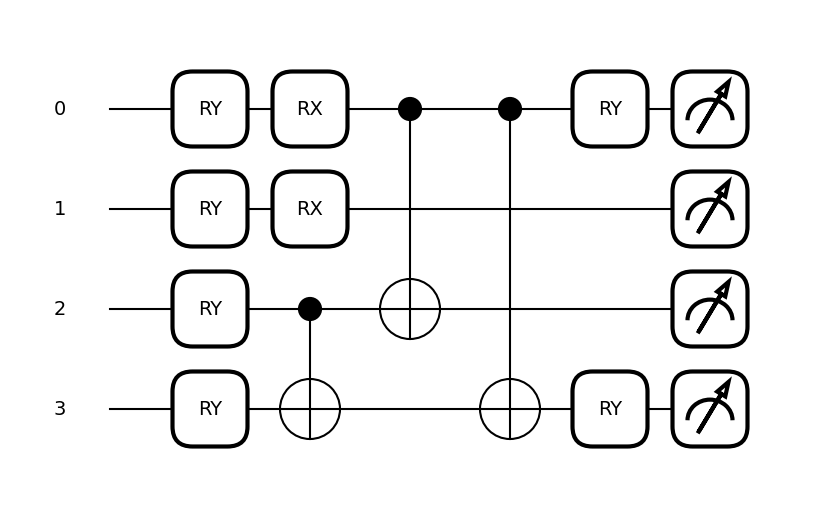

In [5]:
qlayer = qml.qnn.TorchLayer(circuit, {"weights": (n_weights,)})
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5])
fig.show()

In [6]:
def extract_image_patches(x):
    # Do TF 'SAME' Padding
    B, C, H, W = x.shape  
    #x = torch.arange(B*C*H*W).view(B, C, H, W)
    kernel_h, kernel_w = 2, 2
    stride = 2

    patches = x.unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
      
    patches = patches.contiguous().view(B, H // stride, W // stride, -1)

    return patches

In [7]:
import torch.nn as nn

class HQNNQuanv(nn.Module):
    def __init__(self):  
        super(HQNNQuanv, self).__init__()

        # Replace PennyLane KerasLayer (See Note below)
        self.quanv_layer = qlayer

        self.flatten = nn.Flatten()
        self.dense = nn.Linear(14 * 14 * 4, 10) # Adjusted input features for dense layer

    def forward(self, inputs):
        patches = extract_image_patches(inputs)  

        # Batching for PennyLane Layer
        batch_patches = patches.reshape(-1, 4)
        quanvoluted_patches = torch.stack([self.quanv_layer(patch) for patch in batch_patches])
        quanvoluted_patches = quanvoluted_patches.reshape(inputs.shape[0], 14, 14, 4)

        out = self.flatten(quanvoluted_patches)
        out = self.dense(out)
        return out

In [8]:
model = HQNNQuanv() 
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = F.cross_entropy

train_loader, test_loader = load_dataset(n_train, n_test, batch_size)

Number of training samples: 2000
Number of test samples: 400


In [9]:
train_losses = []

for epoch in range(n_epochs):

    # ---- Training Phase ----
    running_loss = 0.0 
    correct = 0  
    total = 0  # Track total samples for accuracy calculation

    for i, (images, labels) in enumerate(train_loader):
        # --- 2. Forward Pass ---
        outputs = model(images)

        # --- 3. Loss Calculation ---
        loss = loss_fn(outputs, labels)
        train_losses.append(loss.item())
        # --- 4. Backpropagation and Optimization ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  
        train_losses.append(loss.item())  # Store loss for each batch

        # Accuracy calculation for the epoch
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy =  100 * correct / total

    # Periodic Evaluation and Logging
    print(f'[i] Epoch {epoch + 1}\n\tLoss: {running_loss / len(train_loader):.4f}\n\tAccuracy: {train_accuracy :.2f}%')

# ----- Test Evaluation (After training loop) -----
#test_loss, test_accuracy = evaluate(model, test_loader) 
#print(f'Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
model.eval()

with torch.no_grad():  # Disable gradients for evaluation
    test_losses = []
    correct = 0
    total = 0

    for images, labels in test_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_losses)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}\nTest Accuracy: {test_accuracy:.2f}%')